In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Pytorch-Models

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/.shortcut-targets-by-id/1aJsbt04Jz9xcLP_lg7fvP4Bpdce6GQlC/Pytorch-Models


In [2]:
import os
import json

def count_images(image_dir, exts={".jpg", ".jpeg", ".png", ".bmp", ".webp"}):
    image_count = 0
    for filename in os.listdir(image_dir):
        if os.path.splitext(filename.lower())[1] in exts:
            image_count += 1
    print(f"Total images: {image_count}")

count_images("datasets/surgical_instruments/images/train")
count_images("datasets/surgical_instruments/images/valid")

Total images: 2855
Total images: 841


In [ ]:
# Check train annotations
with open("datasets/surgical_instruments/annotations/instances_train.json") as f:
    train_data = json.load(f)
    print(f"Train images: {len(train_data['images'])}")
    print(f"Train annotations: {len(train_data['annotations'])}")
    print(f"Categories: {train_data['categories']}")

# Check validation
with open("datasets/surgical_instruments/annotations/instances_valid.json") as f:
    valid_data = json.load(f)
    print(f"\nValid images: {len(valid_data['images'])}")
    print(f"Valid annotations: {len(valid_data['annotations'])}")

Train images: 2855
Train annotations: 4895
Categories: [{'id': 1, 'name': 'Grasper'}, {'id': 2, 'name': 'Harmonic_Ace'}, {'id': 3, 'name': 'Myoma_Screw'}, {'id': 4, 'name': 'Needle_Holder'}, {'id': 5, 'name': 'Suction'}, {'id': 6, 'name': 'Trocar'}]

Valid images: 841
Valid annotations: 1215


In [ ]:
# STEP 1: Install compatible PyTorch (2.0.1 + CUDA 11.7)
!pip install torch==2.0.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

# STEP 2: Install OpenMMLab tools
!pip install -U openmim
!mim install "mmengine>=0.7.4"
!mim install "mmcv==2.1.0"

# STEP 3: Clone MMDetection & install
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -e .

In [2]:
# STEP 4: Final check
!python -c "import torch; import mmcv; import mmdet; print('PyTorch:', torch.__version__); print('MMCV:', mmcv.__version__); print('MMDet:', mmdet.__version__)"

PyTorch: 2.0.1+cu117
MMCV: 2.1.0
MMDet: 3.3.0


In [ ]:
!pip install numpy==1.24.4

In [2]:
!ls mmdetection/configs/mask2former/

mask2former_r101_8xb2-lsj-50e_coco-panoptic.py
mask2former_r101_8xb2-lsj-50e_coco.py
mask2former_r50_8xb2-lsj-50e_coco-panoptic.py
mask2former_r50_8xb2-lsj-50e_coco.py
mask2former_r50_sis.py
mask2former_swin-b-p4-w12-384_8xb2-lsj-50e_coco-panoptic.py
mask2former_swin-b-p4-w12-384-in21k_8xb2-lsj-50e_coco-panoptic.py
mask2former_swin-l-p4-w12-384-in21k_16xb1-lsj-100e_coco-panoptic.py
mask2former_swin-s-p4-w7-224_8xb2-lsj-50e_coco-panoptic.py
mask2former_swin-s-p4-w7-224_8xb2-lsj-50e_coco.py
mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic.py
mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco.py
metafile.yml
README.md


In [ ]:
import json
import os

def add_missing_info(file_path):
    """Adds a placeholder 'info' key to a COCO JSON file if missing."""
    if not os.path.exists(file_path):
        print(f"Error: {file_path} not found.")
        return

    with open(file_path, 'r') as f:
        data = json.load(f)

    if 'info' not in data:
        print(f"Adding 'info' key to {file_path}...")
        # Populate with standard COCO placeholders
        data['info'] = {
            "description": "Custom Dataset",
            "url": "",
            "version": "1.0",
            "year": 2024,
            "contributor": "User",
            "date_created": "2024/02/17"
        }

        with open(file_path, 'w') as f:
            json.dump(data, f, indent=4)
        print("Success!")
    else:
        print(f"'info' key already exists in {file_path}.")

# List all your annotation files here
ann_files = [
    'datasets/surgical_instruments/annotations/instances_train.json',
    'datasets/surgical_instruments/annotations/instances_valid.json'
]

for file in ann_files:
    add_missing_info(file)

Adding 'info' key to datasets/surgical_instruments/annotations/instances_train.json...
Success!
Adding 'info' key to datasets/surgical_instruments/annotations/instances_valid.json...
Success!


In [ ]:
custom_cfg = """
_base_ = 'mask2former_r50_8xb2-lsj-50e_coco.py'

# Custom classes
dataset_type = 'CocoDataset'
metainfo = dict(classes=("Grasper","Harmonic_Ace", "Myoma_Screw", "Needle_Holder", "Suction", "Trocar"))
num_things_classes = 6
num_stuff_classes = 0
num_classes = num_things_classes + num_stuff_classes

# Paths
data_root = '/content/gdrive/MyDrive/Pytorch-Models/datasets/surgical_instruments/'
train_ann = data_root + 'annotations/instances_train.json'
val_ann = data_root + 'annotations/instances_valid.json'
train_img = data_root + 'images/train/'
val_img = data_root + 'images/valid/'

# Pipelines
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', scale=(512, 512), keep_ratio=False),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(512, 512), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(512, 512), keep_ratio=False),
    dict(type='Pad', size=(512, 512), pad_val=dict(img=(114, 114, 114))),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='PackDetInputs', meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape', 'scale_factor'))
]

# Data loader
train_dataloader = dict(
    batch_size=4,
    num_workers=2,
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        ann_file=train_ann,
        data_prefix=dict(img=train_img),
        filter_cfg=dict(filter_empty_gt=True, min_size=32),
        pipeline=train_pipeline,
        metainfo=dict(classes=("Grasper","Harmonic_Ace", "Myoma_Screw", "Needle_Holder", "Suction", "Trocar")),
    )
)

val_dataloader = dict(
    batch_size=4,
    num_workers=2,
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        ann_file=val_ann,
        data_prefix=dict(img=val_img),
        pipeline=test_pipeline,
        test_mode=True,
        metainfo=dict(classes=("Grasper","Harmonic_Ace", "Myoma_Screw", "Needle_Holder", "Suction", "Trocar")),
    )
)

test_dataloader = val_dataloader

# Evaluator
val_evaluator = dict(type='CocoMetric', ann_file=val_ann, metric=['bbox', 'segm'])
test_evaluator = val_evaluator

# Model
model = dict(
    panoptic_head=dict(
        num_things_classes=num_things_classes,
        num_stuff_classes=num_stuff_classes,
        loss_cls=dict(class_weight=[1.0] * num_classes + [0.1])),
    panoptic_fusion_head=dict(
        num_things_classes=num_things_classes,
        num_stuff_classes=num_stuff_classes),
    test_cfg=dict(panoptic_on=False))

# Schedule
max_iters = 2139
interval = 713
train_cfg = dict(type='IterBasedTrainLoop', max_iters=max_iters, val_interval=interval)

val_cfg = dict(type='ValLoop')
test_cfg = dict(type='TestLoop')

# Optimizer
optim_wrapper = dict(
    optimizer=dict(type='AdamW', lr=0.0001, weight_decay=0.05))

# Learning policy
param_scheduler = [
    dict(
        type='MultiStepLR',
        begin=0,
        end=3,
        by_epoch=True,
        milestones=[2, 3],
        gamma=0.1
    )
]

# Logging and checkpointing
default_hooks = dict(
    logger=dict(type='LoggerHook', interval=713),
    checkpoint=dict(type='CheckpointHook', interval=713)
)

# Output path
work_dir = '/content/gdrive/MyDrive/Pytorch-Models/mmdetection/mmdet_outputs/mask2former_r50_sis'

# Load pretrained COCO model
load_from = 'https://download.openmmlab.com/mmdetection/v3.0/mask2former/mask2former_r50_8xb2-lsj-50e_coco/mask2former_r50_8xb2-lsj-50e_coco_20220506_191028-41b088b6.pth'
"""

with open('mmdetection/configs/mask2former/mask2former_r50_sis.py', 'w') as f:
    f.write(custom_cfg)

In [ ]:
!python mmdetection/tools/train.py mmdetection/configs/mask2former/mask2former_r50_sis.py --resume --amp

Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.1+cu117
02/17 12:19:25 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 288778882
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.5, V12.5.82
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA R

In [ ]:
!python mmdetection/tools/test.py mmdetection/configs/mask2former/mask2former_r50_sis.py mmdetection/mmdet_outputs/mask2former_r50_sis/iter_2139.pth

Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.1+cu117
02/17 13:33:12 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1211021100
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.5, V12.5.82
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA 

In [3]:
from mmdet.apis import init_detector, inference_detector
import mmcv

# Config and checkpoint paths
config_file = 'mmdetection/configs/mask2former/mask2former_r50_sis.py'
checkpoint_file = 'mmdetection/mmdet_outputs/mask2former_r50_sis/iter_2139.pth'

# Initialize the model
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or 'cpu'

# Image path
img = 'datasets/surgical_instruments/images/valid/Laparoscopic-Surgery-for-Large-Intramural-Fibroid-41-_jpg.rf.2b8540beea87d68d66321b44567672e9.jpg'

# Run inference
result = inference_detector(model, img)
print(result)

Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.1+cu117


Loads checkpoint by local backend from path: mmdetection/mmdet_outputs/mask2former_r50_sis/iter_2139.pth


/usr/local/lib/python3.11/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<DetDataSample(

    META INFORMATION
    img_shape: (512, 512)
    img_path: 'datasets/surgical_instruments/images/valid/Laparoscopic-Surgery-for-Large-Intramural-Fibroid-41-_jpg.rf.2b8540beea87d68d66321b44567672e9.jpg'
    ori_shape: (1080, 1920)
    scale_factor: (0.26666666666666666, 0.4740740740740741)
    pad_shape: (512, 512)
    img_id: 0
    batch_input_shape: (512, 512)

    DATA FIELDS
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            masks: tensor([[[False, False, False,  ..., False, False, False],
                         [False, False, False,  ..., False, False, False],
                         [False, False, False,  ..., False, False, False],
                         ...,
                         [False, False, False,  ..., False, False, False],
                         [False, False, False,  ..., False, False, False],
                         [False, False, False,  ..., False, False, False]],
          

Loads checkpoint by local backend from path: mmdetection/mmdet_outputs/mask2former_r50_sis/iter_2139.pth


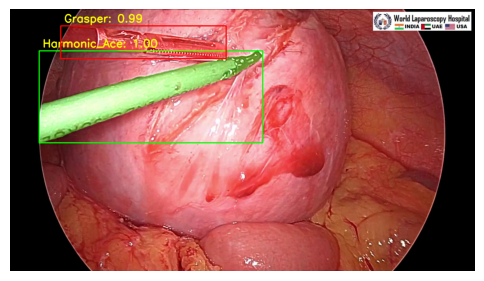

In [4]:
from mmdet.apis import init_detector, inference_detector
import mmcv
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np

# Class labels
CLASS_LABELS = ["Grasper","Harmonic_Ace", "Myoma_Screw", "Needle_Holder", "Suction", "Trocar"]

fixed_colors = [
    (0, 0, 255),     # Red - Grasper
    (0, 255, 0),     # Green - Harmonic_Ace
    (255, 0, 0),     # Blue - Myoma_Screw
    (0, 255, 255),   # Yellow - Needle_Holder
    (255, 0, 255),   # Magenta - Suction
    (255, 255, 0)    # Cyan - Trocar
]

# Config and checkpoint paths
config_file = 'mmdetection/configs/mask2former/mask2former_r50_sis.py'
checkpoint_file = 'mmdetection/mmdet_outputs/mask2former_r50_sis/iter_2139.pth'

# Initialize the model
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or 'cpu'

def draw_bbox_with_label(img, bbox, label, score, color=(0, 0, 255), thickness=3):
    xmin, ymin, xmax, ymax = map(int, bbox)
    # Draw rectangle
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, thickness)
    # Put label text
    cv2.putText(
        img, f"{label}: {score:.2f}", (xmin + 15, ymin - 15),
        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 3, cv2.LINE_AA
    )

# Image path
img_path = 'datasets/surgical_instruments/images/valid/Laparoscopic-Surgery-for-Large-Intramural-Fibroid-41-_jpg.rf.2b8540beea87d68d66321b44567672e9.jpg'
img = cv2.imread(img_path)
if img is None:
    raise Exception("Image not found or unreadable")

# Run inference
results = inference_detector(model, img_path)

# Access the prediction results from the DetDataSample object
pred_instances = results.pred_instances

CONF_THRESHOLD = 0.3
img_with_masks = img.copy()

# Draw boxes and labels
# pred_instances.bboxes, pred_instances.scores, and pred_instances.labels are tensors
for i in range(len(pred_instances.bboxes)):
    score = pred_instances.scores[i]
    if score < CONF_THRESHOLD:
        continue

    # 1. Get Class and Color
    label_id = pred_instances.labels[i].item()
    class_name = CLASS_LABELS[label_id]
    color = fixed_colors[label_id]

    # 2. Extract and Process Mask
    # pred_instances.masks is a boolean tensor of shape (N, H, W)
    mask = pred_instances.masks[i].cpu().numpy()

    # Create a colored version of the mask
    colored_mask = np.zeros_like(img, dtype=np.uint8)
    colored_mask[mask] = color

    # 3. Overlay Mask onto Image (Alpha Blending)
    alpha = 0.4  # Transparency level
    img_with_masks = cv2.addWeighted(img_with_masks, 1.0, colored_mask, alpha, 0)

    # 4. Draw Bounding Box and Label
    bbox = pred_instances.bboxes[i].tolist()
    draw_bbox_with_label(img_with_masks, bbox, class_name, score, color=color)

# Show result
img_with_bbox_rgb = cv2.cvtColor(img_with_masks, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(img_with_bbox_rgb)
plt.show()

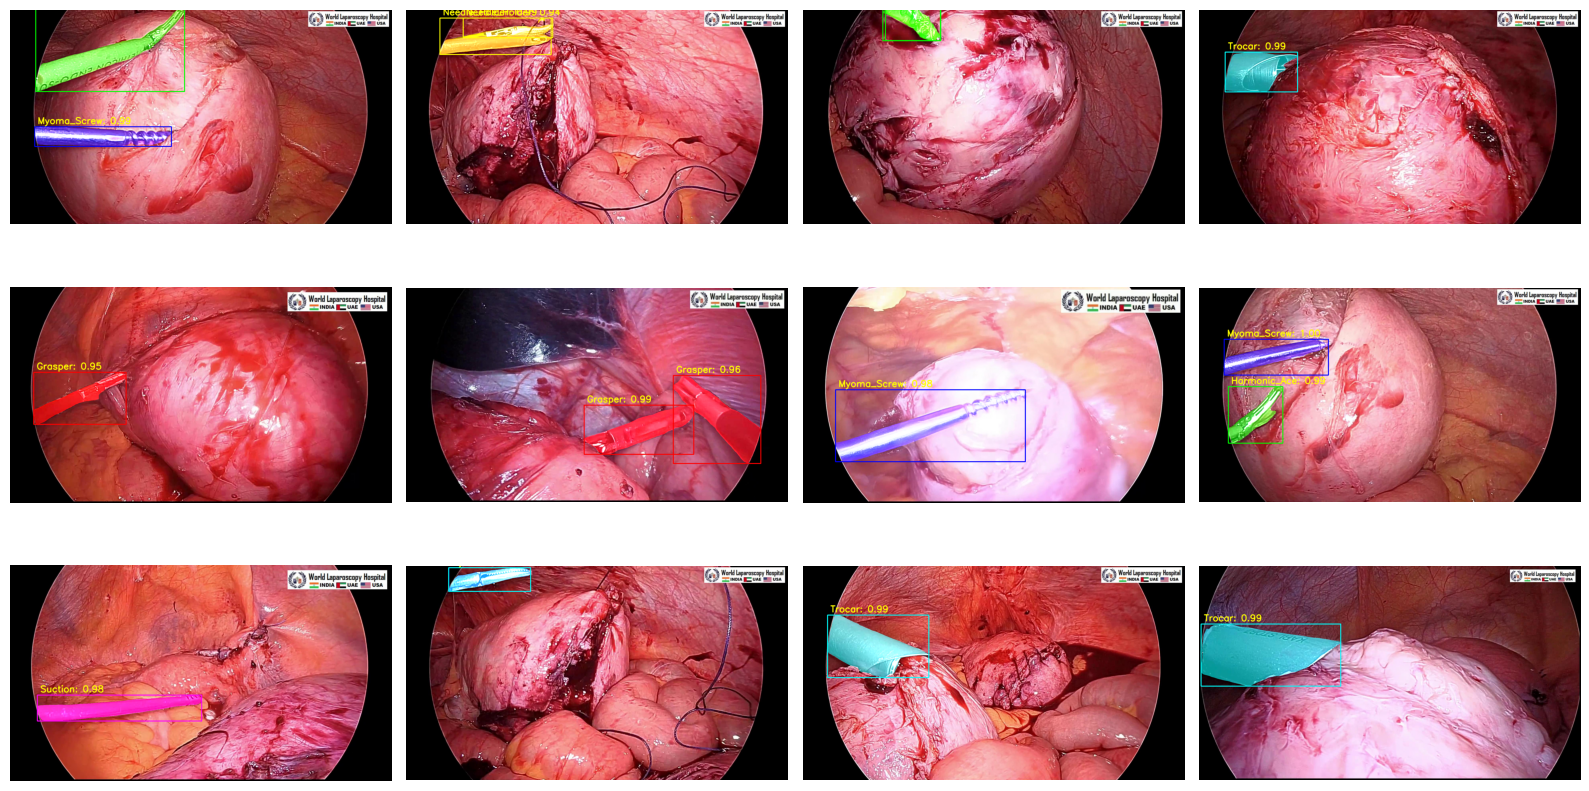

In [ ]:
import os
import random
# ---------------- CONFIG ----------------
val_dir = "datasets/surgical_instruments/images/valid/"

# Class labels
CLASS_LABELS = ["Grasper","Harmonic_Ace", "Myoma_Screw", "Needle_Holder", "Suction", "Trocar"]

fixed_colors = [
    (0, 0, 255),     # Red - Grasper
    (0, 255, 0),     # Green - Harmonic_Ace
    (255, 0, 0),     # Blue - Myoma_Screw
    (0, 255, 255),   # Yellow - Needle_Holder
    (255, 0, 255),   # Magenta - Suction
    (255, 255, 0)    # Cyan - Trocar
]

# visualization layout
N = 12
cols = 4
rows = int(np.ceil(N / cols))

# random image selection
all_imgs = [os.path.join(val_dir, f)
            for f in os.listdir(val_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, N)

plt.figure(figsize=(4 * cols, 3 * rows))

for ii, image in enumerate(sample_imgs):
    plt.subplot(3, 4, ii+1)

    img = cv2.imread(image)

    results = inference_detector(model, image)

    # Access the prediction results from the DetDataSample object
    pred_instances = results.pred_instances

    CONF_THRESHOLD = 0.3
    img_with_masks = img.copy()

    # Draw boxes and labels
    # pred_instances.bboxes, pred_instances.scores, and pred_instances.labels are tensors
    for i in range(len(pred_instances.bboxes)):
        score = pred_instances.scores[i]
        if score < CONF_THRESHOLD:
            continue

        # 1. Get Class and Color
        label_id = pred_instances.labels[i].item()
        class_name = CLASS_LABELS[label_id]
        color = fixed_colors[label_id]

        # 2. Extract and Process Mask
        # pred_instances.masks is a boolean tensor of shape (N, H, W)
        mask = pred_instances.masks[i].cpu().numpy()

        # Create a colored version of the mask
        colored_mask = np.zeros_like(img, dtype=np.uint8)
        colored_mask[mask] = color

        # 3. Overlay Mask onto Image (Alpha Blending)
        alpha = 0.6  # Transparency level
        img_with_masks = cv2.addWeighted(img_with_masks, 1.0, colored_mask, alpha, 0)

        # 4. Draw Bounding Box and Label
        bbox = pred_instances.bboxes[i].tolist()
        draw_bbox_with_label(img_with_masks, bbox, class_name, score, color=color)

    plt.subplot(rows, cols, ii + 1)
    plt.imshow(cv2.cvtColor(img_with_masks, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
!pip install onnx onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 24.0 MB/s eta 0:00:00
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4

In [6]:
import torch

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [8]:
model = model.cpu()
dummy_input = torch.randn(1, 3, 512, 512).cpu()

In [ ]:
onnx_model_path = "mmdetection/mmdet_outputs/mask2former_r50_sis/iter_2139.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    opset_version=16,
    input_names=["input"],
    output_names=["boxes", "labels", "scores"],
    dynamic_axes={
        "input": {0: "batch_size", 2: "height", 3: "width"},
        "boxes": {0: "num_boxes"},
        "labels": {0: "num_boxes"},
        "scores": {0: "num_boxes"},
    },
    do_constant_folding=True,
)
print(f"ONNX export {onnx_model_path} completed successfully!")

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX export mmdetection/mmdet_outputs/mask2former_r50_sis/iter_2139.onnx completed successfully!


In [9]:
!pip install onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.6/252.6 MB 4.1 MB/s eta 0:00:00


In [22]:
import onnxruntime
import numpy as np
import cv2
import torch
import os
import random

# Load image and preprocess
img_path = "datasets/surgical_instruments/images/valid/Laparoscopic-Surgery-for-Large-Intramural-Fibroid-41-_jpg.rf.2b8540beea87d68d66321b44567672e9.jpg"

mean = np.array([123.675, 116.28, 103.53], dtype=np.float32)
std = np.array([58.395, 57.12, 57.375], dtype=np.float32)

img = cv2.imread(img_path)
img_resized = cv2.resize(img, (512, 512))
img_input = (img_resized[:, :, ::-1].astype(np.float32) - mean) / std
img_input = img_input.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

# Run inference
session = onnxruntime.InferenceSession("mmdetection/mmdet_outputs/mask2former_r50_sis/iter_2139.onnx", providers=["CUDAExecutionProvider"])
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: img_input})

# outputs is a list, often like [boxes, scores, keypoints]
print("Output:", [o.shape for o in outputs])

Output: [(1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128)]


In [ ]:
for i, o in enumerate(outputs): print(f"Idx {i}: Max={o.max():.2f}, Min={o.min():.2f}, Shape={o.shape}")

Idx 0: Max=5.63, Min=-4.25, Shape=(1, 100, 7)
Idx 1: Max=9.25, Min=-6.28, Shape=(1, 100, 7)
Idx 2: Max=8.74, Min=-5.32, Shape=(1, 100, 7)
Idx 3: Max=9.39, Min=-5.56, Shape=(1, 100, 7)
Idx 4: Max=9.22, Min=-6.27, Shape=(1, 100, 7)
Idx 5: Max=8.97, Min=-6.71, Shape=(1, 100, 7)
Idx 6: Max=9.62, Min=-6.27, Shape=(1, 100, 7)
Idx 7: Max=9.75, Min=-6.70, Shape=(1, 100, 7)
Idx 8: Max=9.44, Min=-6.77, Shape=(1, 100, 7)
Idx 9: Max=9.74, Min=-6.61, Shape=(1, 100, 7)
Idx 10: Max=103.98, Min=-184.66, Shape=(1, 100, 128, 128)
Idx 11: Max=155.03, Min=-266.26, Shape=(1, 100, 128, 128)
Idx 12: Max=149.69, Min=-202.57, Shape=(1, 100, 128, 128)
Idx 13: Max=154.44, Min=-157.35, Shape=(1, 100, 128, 128)
Idx 14: Max=166.46, Min=-136.99, Shape=(1, 100, 128, 128)
Idx 15: Max=159.18, Min=-166.02, Shape=(1, 100, 128, 128)
Idx 16: Max=174.67, Min=-198.52, Shape=(1, 100, 128, 128)
Idx 17: Max=168.63, Min=-228.01, Shape=(1, 100, 128, 128)
Idx 18: Max=166.15, Min=-245.57, Shape=(1, 100, 128, 128)
Idx 19: Max=179.11

In [ ]:
def debug_all_queries(outputs):
    bboxes = outputs[9][0] # (100, 7)

    # Sort by the score column (index 4) descending
    sorted_indices = np.argsort(bboxes[:, 4])[::-1]

    print("Top 10 Raw Scores from Index 4:")
    for i in range(10):
        idx = sorted_indices[i]
        print(f"Query {idx}: Score={bboxes[idx, 4]:.4f}, Label={bboxes[idx, 5]}")

debug_all_queries(outputs)

Top 10 Raw Scores from Index 4:
Query 1: Score=1.0078, Label=-0.23533529043197632
Query 12: Score=-4.0636, Label=-3.270738363265991
Query 58: Score=-4.1206, Label=-3.4484217166900635
Query 24: Score=-4.1748, Label=-4.004298210144043
Query 38: Score=-4.1752, Label=-3.4438021183013916
Query 73: Score=-4.2171, Label=-3.7284438610076904
Query 64: Score=-4.2229, Label=-3.8400025367736816
Query 19: Score=-4.2476, Label=-3.5639455318450928
Query 3: Score=-4.2507, Label=-3.9832067489624023
Query 82: Score=-4.3389, Label=-3.6590912342071533


Verified Max Score: 0.9991 | Objects to draw: 2


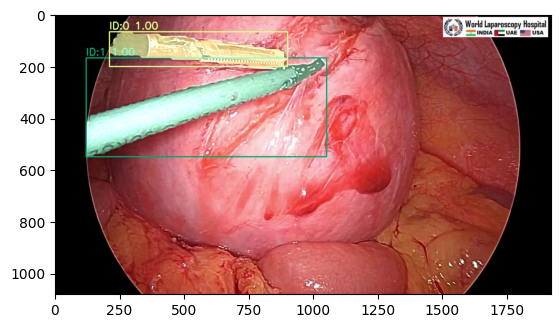

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_results(img_orig, outputs, threshold=0.8):
    h, w = img_orig.shape[:2]
    annotated_img = img_orig.copy()

    # 1. FIND THE CLASS TENSOR
    # We need the tensor that has shape (1, 100, N) where N >= 6.
    # Based on standard MMDetection exports:
    # Index 9 is usually the final CLASS LOGITS
    # Index 19 is the final MASK LOGITS

    final_cls_logits = outputs[9][0]   # Shape: (100, num_classes + 1)
    final_mask_logits = outputs[19][0] # Shape: (100, 128, 128)

    # 2. PROPER ACTIVATION
    # Mask2Former uses Softmax over classes for each query
    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / e_x.sum(axis=-1, keepdims=True)

    def sigmoid(x):
        return 1 / (1 + np.exp(-np.clip(x, -50, 50)))

    # Get probabilities for all 100 queries
    # Query scores are the max probability across the classes (excluding background)
    probs = softmax(final_cls_logits)

    # In MMDetection, the last column is usually the "Background" class
    scores = np.max(probs[:, :-1], axis=1)
    labels = np.argmax(probs[:, :-1], axis=1)

    # 3. FILTER
    keep_indices = np.where(scores > threshold)[0]
    print(f"Verified Max Score: {np.max(scores):.4f} | Objects to draw: {len(keep_indices)}")

    for idx in keep_indices:
        score = scores[idx]
        label = labels[idx]

        # 4. GENERATE MASK
        m_logits = final_mask_logits[idx]
        m_prob = sigmoid(m_logits)
        m_resized = cv2.resize(m_prob, (w, h), interpolation=cv2.INTER_CUBIC)
        binary_mask = (m_resized > 0.5).astype(np.uint8)

        if not binary_mask.any(): continue

        color = [random.randint(0, 255) for _ in range(3)]

        # Apply Mask Overlay
        colored_mask = np.zeros_like(img_orig, dtype=np.uint8)
        colored_mask[binary_mask == 1] = color
        annotated_img = cv2.addWeighted(colored_mask, 0.6, annotated_img, 1.0, 0)

        # 5. GET BOX FROM MASK (Most reliable for Mask2Former ONNX)
        # Instead of guessing the box tensor index, derive it from the mask
        y, x = np.where(binary_mask)
        if len(x) > 0 and len(y) > 0:
            x1, y1, x2, y2 = np.min(x), np.min(y), np.max(x), np.max(y)
            cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 3)
            cv2.putText(annotated_img, f"ID:{label} {score:.2f}", (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, color, 3)

    return annotated_img

# EXECUTE
result_viz = visualize_results(img, outputs, threshold=0.5)
plt.imshow(cv2.cvtColor(result_viz, cv2.COLOR_BGR2RGB))
plt.show()

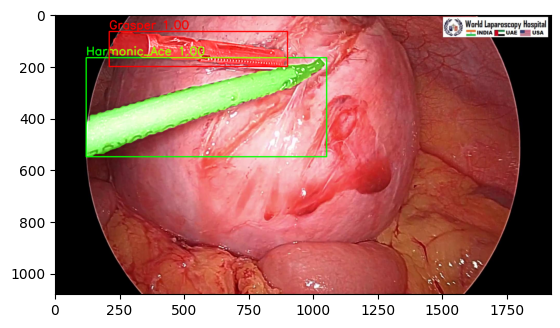

In [23]:
import cv2
import numpy as np
import os
import random
from matplotlib import pyplot as plt

# Class labels
CLASS_LABELS = ["Grasper","Harmonic_Ace", "Myoma_Screw", "Needle_Holder", "Suction", "Trocar"]

fixed_colors = [
    (0, 0, 255),     # Red - Grasper
    (0, 255, 0),     # Green - Harmonic_Ace
    (255, 0, 0),     # Blue - Myoma_Screw
    (0, 255, 255),   # Yellow - Needle_Holder
    (255, 0, 255),   # Magenta - Suction
    (255, 255, 0)    # Cyan - Trocar
]

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -50, 50)))

def visualize_results(img_orig, outputs, threshold=0.8):
    h, w = img_orig.shape[:2]
    annotated_img = img_orig.copy()

    final_cls_logits = outputs[9][0]   # Shape: (100, num_classes + 1)
    final_mask_logits = outputs[19][0] # Shape: (100, 128, 128)

    # Get probabilities for all 100 queries
    # Query scores are the max probability across the classes (excluding background)
    probs = softmax(final_cls_logits)

    # In MMDetection, the last column is usually the "Background" class
    scores = np.max(probs[:, :-1], axis=1)
    labels = np.argmax(probs[:, :-1], axis=1)

    keep_indices = np.where(scores > threshold)[0]
    # print(f"Verified Max Score: {np.max(scores):.4f} | Objects to draw: {len(keep_indices)}")

    for idx in keep_indices:
        score = scores[idx]
        label = labels[idx]

        m_logits = final_mask_logits[idx]
        m_prob = sigmoid(m_logits)
        m_resized = cv2.resize(m_prob, (w, h), interpolation=cv2.INTER_CUBIC)
        binary_mask = (m_resized > 0.5).astype(np.uint8)

        if not binary_mask.any(): continue

        color = fixed_colors[label]
        labeltext = CLASS_LABELS[label]

        # Apply Mask Overlay
        colored_mask = np.zeros_like(img_orig, dtype=np.uint8)
        colored_mask[binary_mask == 1] = color
        annotated_img = cv2.addWeighted(colored_mask, 0.6, annotated_img, 1.0, 0)

        # Instead of guessing the box tensor index, derive it from the mask
        y, x = np.where(binary_mask)
        if len(x) > 0 and len(y) > 0:
            x1, y1, x2, y2 = np.min(x), np.min(y), np.max(x), np.max(y)
            cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 3)
            cv2.putText(annotated_img, f"{labeltext} {score:.2f}", (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)

    return annotated_img

# EXECUTE
result_viz = visualize_results(img, outputs, threshold=0.5)
plt.imshow(cv2.cvtColor(result_viz, cv2.COLOR_BGR2RGB))
plt.show()

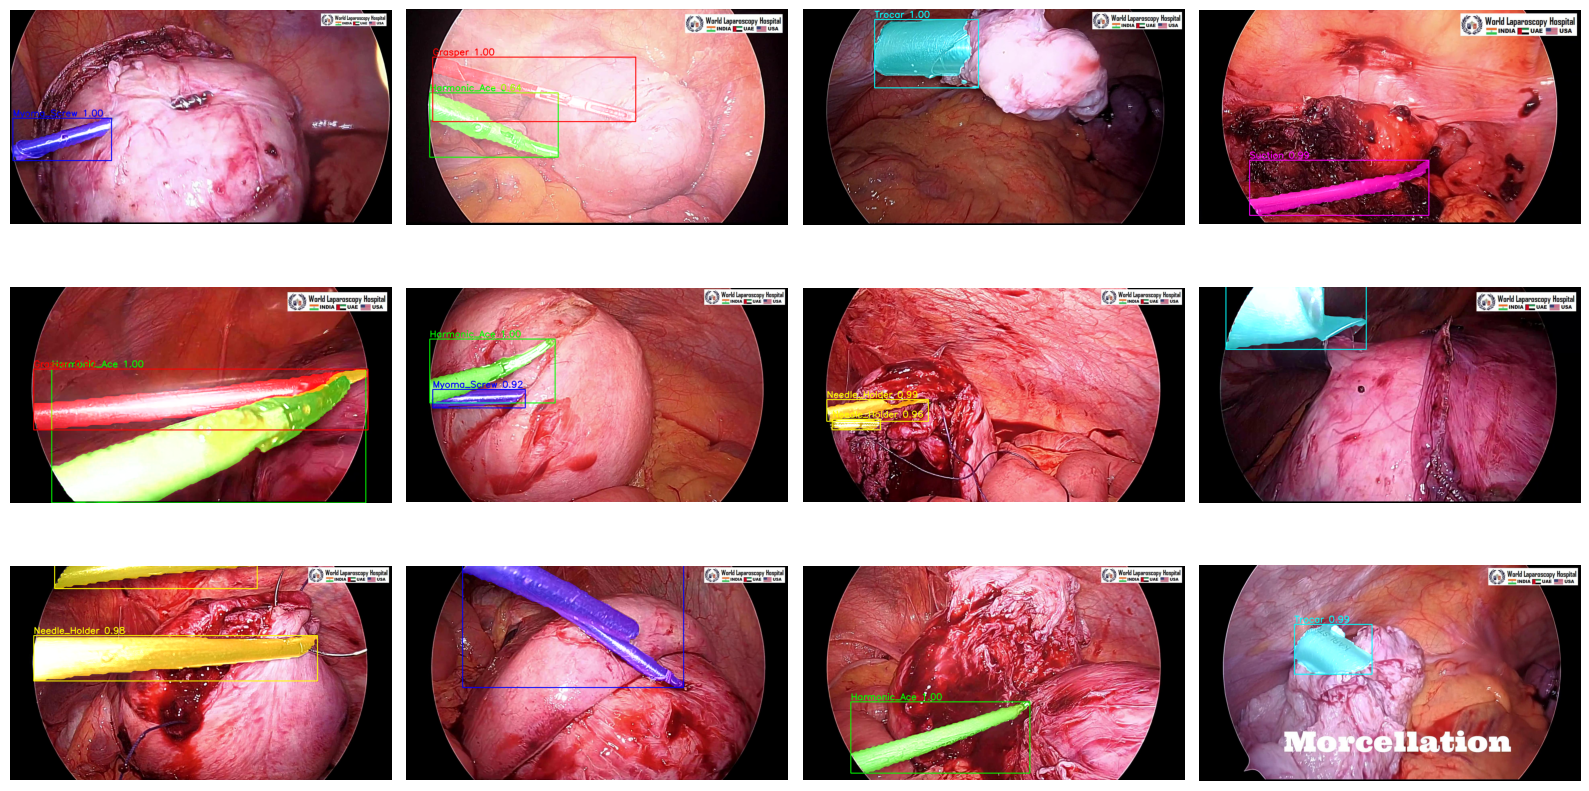

In [25]:
mean = np.array([123.675, 116.28, 103.53], dtype=np.float32)
std = np.array([58.395, 57.12, 57.375], dtype=np.float32)

session = onnxruntime.InferenceSession("mmdetection/mmdet_outputs/mask2former_r50_sis/iter_2139.onnx", providers=["CUDAExecutionProvider"])
input_name = session.get_inputs()[0].name

CONF_THR = 0.5

# ---------------- CONFIG ----------------
val_dir = "datasets/surgical_instruments/images/valid/"

# visualization layout
N = 12
cols = 4
rows = int(np.ceil(N / cols))

# random image selection
all_imgs = [os.path.join(val_dir, f)
            for f in os.listdir(val_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, N)

plt.figure(figsize=(4 * cols, 3 * rows))

for ii, image in enumerate(sample_imgs):
    plt.subplot(3, 4, ii+1)

    img = cv2.imread(image)
    img_resized = cv2.resize(img, (512, 512))
    img_input = (img_resized[:, :, ::-1].astype(np.float32) - mean) / std
    img_input = img_input.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

    outputs = session.run(None, {input_name: img_input})

    result_viz = visualize_results(img, outputs, threshold=CONF_THR)

    plt.subplot(rows, cols, ii + 1)
    plt.imshow(cv2.cvtColor(result_viz, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [10]:
with torch.no_grad():
    outputs = model(dummy_input)
print("Types in outputs:", [type(o) for o in outputs])

for i, o in enumerate(outputs):
    if isinstance(o, (list, tuple)):
        # If it's a tuple, show its length and the shape of its first item
        print(f"Index {i} (Tuple): len={len(o)}, first_item_shape={o[0].shape if len(o)>0 else 'empty'}")
    elif hasattr(o, 'shape'):
        # If it's a Tensor, show the shape directly
        print(f"Index {i} (Tensor): shape={o.shape}")
    else:
        print(f"Index {i} (Other): {type(o)}")

Types in outputs: [<class 'list'>, <class 'list'>]
Index 0 (Tuple): len=10, first_item_shape=torch.Size([1, 100, 7])
Index 1 (Tuple): len=10, first_item_shape=torch.Size([1, 100, 128, 128])


In [11]:
with torch.no_grad():
    traced_model = torch.jit.trace(model, dummy_input)

/usr/local/lib/python3.11/dist-packages/mmcv/ops/multi_scale_deform_attn.py:335: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert (spatial_shapes[:, 0] * spatial_shapes[:, 1]).sum() == num_value
/usr/local/lib/python3.11/dist-packages/mmcv/ops/multi_scale_deform_attn.py:351: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if reference_points.shape[-1] == 2:
/usr/local/lib/python3.11/dist-packages/mmcv/ops/multi_scale_deform_attn.py:136: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape w

In [12]:
traced_model.save("mmdetection/mmdet_outputs/mask2former_r50_sis/iter_2139_traced.pt")

In [26]:
import numpy as np
import cv2
import os
import random
import torch

# Load image and preprocess
img_path = "datasets/surgical_instruments/images/valid/Laparoscopic-Surgery-for-Large-Intramural-Fibroid-41-_jpg.rf.2b8540beea87d68d66321b44567672e9.jpg"

mean = np.array([123.675, 116.28, 103.53], dtype=np.float32)
std = np.array([58.395, 57.12, 57.375], dtype=np.float32)

img = cv2.imread(img_path)
img_resized = cv2.resize(img, (512, 512))
img_input = (img_resized[:, :, ::-1].astype(np.float32) - mean) / std
img_input = img_input.transpose(2, 0, 1)  # Result: (3, 640, 640)
img_input = torch.from_numpy(img_input).float().unsqueeze(0) # Add Batch Dim

model_ts = torch.jit.load("mmdetection/mmdet_outputs/mask2former_r50_sis/iter_2139_traced.pt")
model_ts.eval()

img_input = img_input.to("cpu")

with torch.no_grad():
    outputs = model_ts(img_input)

print("Types in outputs:", [type(o) for o in outputs])

for i, o in enumerate(outputs):
    if isinstance(o, (list, tuple)):
        # If it's a tuple, show its length and the shape of its first item
        print(f"Index {i} (Tuple): len={len(o)}, first_item_shape={o[0].shape if len(o)>0 else 'empty'}")
    elif hasattr(o, 'shape'):
        # If it's a Tensor, show the shape directly
        print(f"Index {i} (Tensor): shape={o.shape}")
    else:
        print(f"Index {i} (Other): {type(o)}")

Types in outputs: [<class 'list'>, <class 'list'>]
Index 0 (Tuple): len=10, first_item_shape=torch.Size([1, 100, 7])
Index 1 (Tuple): len=10, first_item_shape=torch.Size([1, 100, 128, 128])


Output: [(1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128)]
Verified Max Score: 0.9991 | Objects to draw: 2


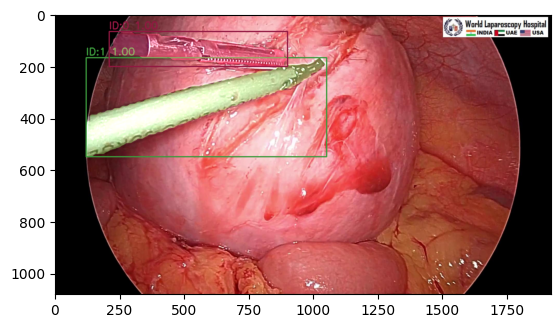

In [17]:
import cv2
import numpy as np
import os
import random
from matplotlib import pyplot as plt

def visualize_results(img_orig, outputs, threshold=0.8):
    h, w = img_orig.shape[:2]
    annotated_img = img_orig.copy()

    # 1. FIND THE CLASS TENSOR
    # We need the tensor that has shape (1, 100, N) where N >= 6.
    # Based on standard MMDetection exports:
    # Index 9 is usually the final CLASS LOGITS
    # Index 19 is the final MASK LOGITS

    final_cls_logits = outputs[9][0]   # Shape: (100, num_classes + 1)
    final_mask_logits = outputs[19][0] # Shape: (100, 128, 128)

    # 2. PROPER ACTIVATION
    # Mask2Former uses Softmax over classes for each query
    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / e_x.sum(axis=-1, keepdims=True)

    def sigmoid(x):
        return 1 / (1 + np.exp(-np.clip(x, -50, 50)))

    # Get probabilities for all 100 queries
    # Query scores are the max probability across the classes (excluding background)
    probs = softmax(final_cls_logits)

    # In MMDetection, the last column is usually the "Background" class
    scores = np.max(probs[:, :-1], axis=1)
    labels = np.argmax(probs[:, :-1], axis=1)

    # 3. FILTER
    keep_indices = np.where(scores > threshold)[0]
    print(f"Verified Max Score: {np.max(scores):.4f} | Objects to draw: {len(keep_indices)}")

    for idx in keep_indices:
        score = scores[idx]
        label = labels[idx]

        # 4. GENERATE MASK
        m_logits = final_mask_logits[idx]
        m_prob = sigmoid(m_logits)
        m_resized = cv2.resize(m_prob, (w, h), interpolation=cv2.INTER_CUBIC)
        binary_mask = (m_resized > 0.5).astype(np.uint8)

        if not binary_mask.any(): continue

        color = [random.randint(0, 255) for _ in range(3)]

        # Apply Mask Overlay
        colored_mask = np.zeros_like(img_orig, dtype=np.uint8)
        colored_mask[binary_mask == 1] = color
        annotated_img = cv2.addWeighted(colored_mask, 0.6, annotated_img, 1.0, 0)

        # 5. GET BOX FROM MASK (Most reliable for Mask2Former ONNX)
        # Instead of guessing the box tensor index, derive it from the mask
        y, x = np.where(binary_mask)
        if len(x) > 0 and len(y) > 0:
            x1, y1, x2, y2 = np.min(x), np.min(y), np.max(x), np.max(y)
            cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 3)
            cv2.putText(annotated_img, f"ID:{label} {score:.2f}", (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, color, 3)

    return annotated_img

final_list = []
for item in outputs:
    if isinstance(item, (tuple, list)):
        for tensor in item:
            final_list.append(tensor.detach().cpu().numpy())
    else:
        final_list.append(item.detach().cpu().numpy())

print("Output:", [o.shape for o in  final_list])

# EXECUTE
result_viz = visualize_results(img, final_list, threshold=0.5)

plt.imshow(cv2.cvtColor(result_viz, cv2.COLOR_BGR2RGB))
plt.show()

Output: [(1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 7), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128), (1, 100, 128, 128)]


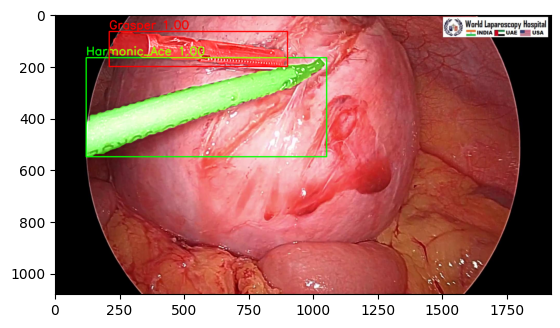

In [28]:
import cv2
import numpy as np
import os
import random
from matplotlib import pyplot as plt

# Class labels
CLASS_LABELS = ["Grasper","Harmonic_Ace", "Myoma_Screw", "Needle_Holder", "Suction", "Trocar"]

fixed_colors = [
    (0, 0, 255),     # Red - Grasper
    (0, 255, 0),     # Green - Harmonic_Ace
    (255, 0, 0),     # Blue - Myoma_Screw
    (0, 255, 255),   # Yellow - Needle_Holder
    (255, 0, 255),   # Magenta - Suction
    (255, 255, 0)    # Cyan - Trocar
]

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -50, 50)))

def visualize_results(img_orig, outputs, threshold=0.8):
    h, w = img_orig.shape[:2]
    annotated_img = img_orig.copy()

    final_cls_logits = outputs[9][0]   # Shape: (100, num_classes + 1)
    final_mask_logits = outputs[19][0] # Shape: (100, 128, 128)

    # Get probabilities for all 100 queries
    # Query scores are the max probability across the classes (excluding background)
    probs = softmax(final_cls_logits)

    # In MMDetection, the last column is usually the "Background" class
    scores = np.max(probs[:, :-1], axis=1)
    labels = np.argmax(probs[:, :-1], axis=1)

    keep_indices = np.where(scores > threshold)[0]
    # print(f"Verified Max Score: {np.max(scores):.4f} | Objects to draw: {len(keep_indices)}")

    for idx in keep_indices:
        score = scores[idx]
        label = labels[idx]

        m_logits = final_mask_logits[idx]
        m_prob = sigmoid(m_logits)
        m_resized = cv2.resize(m_prob, (w, h), interpolation=cv2.INTER_CUBIC)
        binary_mask = (m_resized > 0.5).astype(np.uint8)

        if not binary_mask.any(): continue

        color = fixed_colors[label]
        labeltext = CLASS_LABELS[label]

        # Apply Mask Overlay
        colored_mask = np.zeros_like(img_orig, dtype=np.uint8)
        colored_mask[binary_mask == 1] = color
        annotated_img = cv2.addWeighted(colored_mask, 0.6, annotated_img, 1.0, 0)

        # Instead of guessing the box tensor index, derive it from the mask
        y, x = np.where(binary_mask)
        if len(x) > 0 and len(y) > 0:
            x1, y1, x2, y2 = np.min(x), np.min(y), np.max(x), np.max(y)
            cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 3)
            cv2.putText(annotated_img, f"{labeltext} {score:.2f}", (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)

    return annotated_img

final_list = []
for item in outputs:
    if isinstance(item, (tuple, list)):
        for tensor in item:
            final_list.append(tensor.detach().cpu().numpy())
    else:
        final_list.append(item.detach().cpu().numpy())

print("Output:", [o.shape for o in  final_list])
# EXECUTE
result_viz = visualize_results(img, final_list, threshold=0.5)
plt.imshow(cv2.cvtColor(result_viz, cv2.COLOR_BGR2RGB))
plt.show()

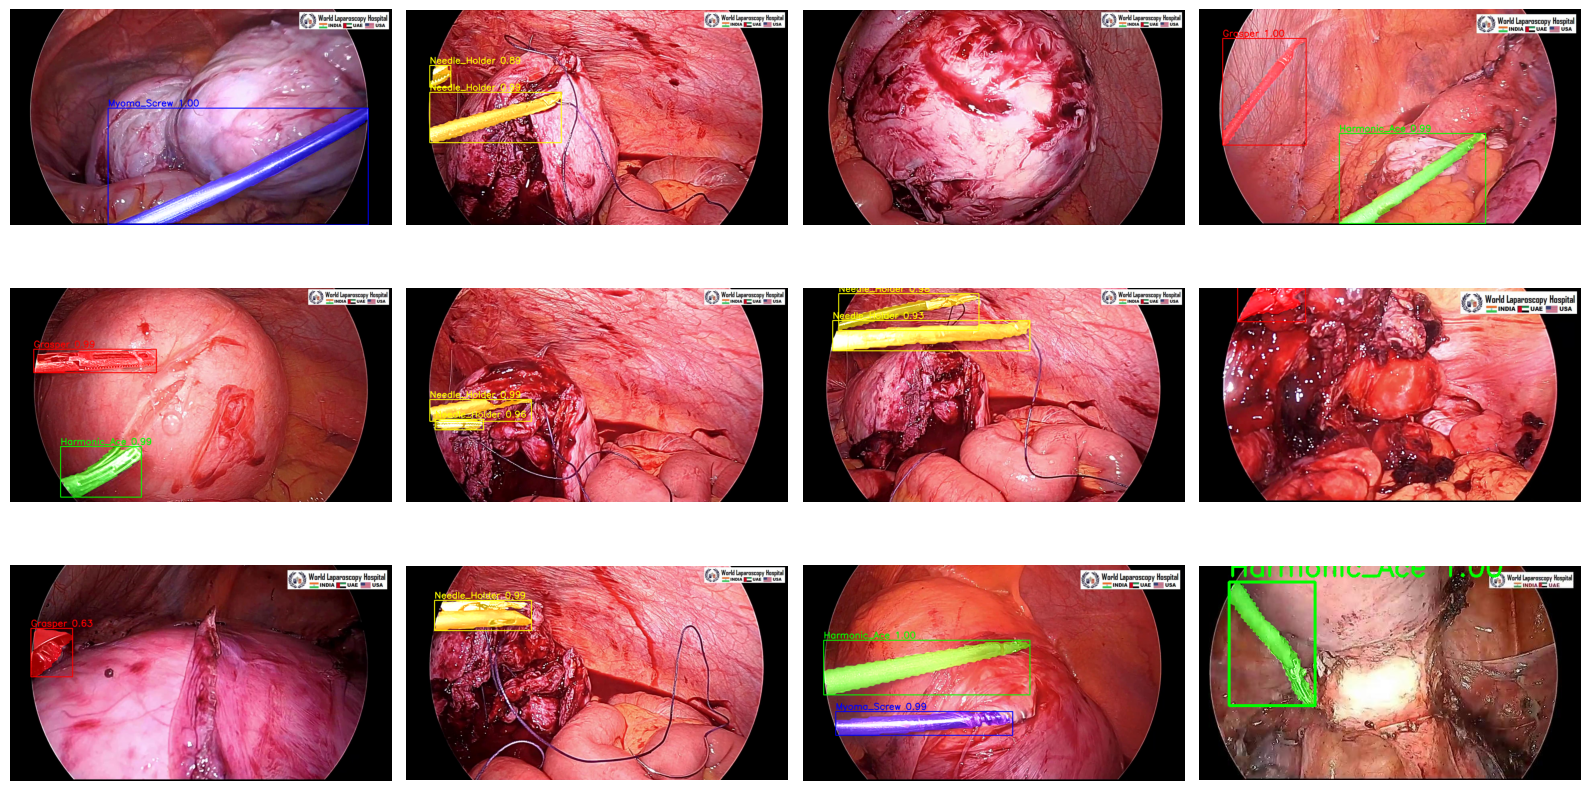

In [31]:
mean = np.array([123.675, 116.28, 103.53], dtype=np.float32)
std = np.array([58.395, 57.12, 57.375], dtype=np.float32)

model_ts = torch.jit.load("mmdetection/mmdet_outputs/mask2former_r50_sis/iter_2139_traced.pt")
model_ts.eval()

CONF_THR = 0.5

# ---------------- CONFIG ----------------
val_dir = "datasets/surgical_instruments/images/valid/"

# visualization layout
N = 12
cols = 4
rows = int(np.ceil(N / cols))

# random image selection
all_imgs = [os.path.join(val_dir, f)
            for f in os.listdir(val_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, N)

plt.figure(figsize=(4 * cols, 3 * rows))

for ii, image in enumerate(sample_imgs):
    plt.subplot(3, 4, ii+1)

    img = cv2.imread(image)
    img_resized = cv2.resize(img, (512, 512))
    img_input = (img_resized[:, :, ::-1].astype(np.float32) - mean) / std
    img_input = img_input.transpose(2, 0, 1)  # Result: (3, 640, 640)
    img_input = torch.from_numpy(img_input).float().unsqueeze(0) # Add Batch Dim

    img_input = img_input.to("cpu")

    with torch.no_grad():
        outputs = model_ts(img_input)

    final_list = []
    for item in outputs:
        if isinstance(item, (tuple, list)):
            for tensor in item:
                final_list.append(tensor.detach().cpu().numpy())
        else:
            final_list.append(item.detach().cpu().numpy())

    result_viz = visualize_results(img, final_list, threshold=CONF_THR)

    plt.subplot(rows, cols, ii + 1)
    plt.imshow(cv2.cvtColor(result_viz, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()